In [ ]:
import sys
sys.path.insert(0, './src')

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from config import load_config
from dataset_coco import COCODetectionDataset
from models import AnchorDETR
from lightning_module import DetectionModule


In [ ]:
config = load_config('./configs/config_coco_anchor_detr_person.json')

DATA_ROOT = config['data']['root_dir']
TRAIN_SPLIT = config['data']['split']
VAL_SPLIT = config['data']['val_split']
TEST_SPLIT = config['data']['test_split']
TARGET_SIZE = tuple(config['data']['target_size'])
BATCH_SIZE = config['data']['batch_size']
NUM_WORKERS = config['data']['num_workers']
MIN_AREA = config['data']['min_area']
FILTER_CATEGORIES = config['data']['filter_categories']
NUM_CLASSES = config['model']['num_classes']

MAX_EPOCHS = config['training']['max_epochs']
LEARNING_RATE = config['training']['learning_rate']
WEIGHT_DECAY = config['training']['weight_decay']
OPTIMIZER = config['training']['optimizer']

EMB_DIM = config['model']['emb_dim']
NHEAD = config['model']['nhead']
ENC_LAYERS = config['model']['enc_layers']
DEC_LAYERS = config['model']['dec_layers']
NUM_PATTERNS = config['model']['num_patterns']
PRETRAINED = config['model']['pretrained']

print(f"Model: Anchor-Based DETR")
print(f"Classes: {NUM_CLASSES} ({', '.join(FILTER_CATEGORIES)})")
print(f"Queries: Dynamic (based on feature map size)")
print(f"Patterns per anchor: {NUM_PATTERNS}")
print(f"Encoder layers: {ENC_LAYERS}, Decoder layers: {DEC_LAYERS}")


Model: Anchor-Based DETR
Classes: 1 (person)
Queries: Dynamic (based on feature map size)
Patterns per anchor: 3
Encoder layers: 6, Decoder layers: 6


In [3]:
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    boxes = [item[1] for item in batch]
    labels = [item[2] for item in batch]
    return images, boxes, labels

train_dataset = COCODetectionDataset(
    root_dir=DATA_ROOT,
    split=TRAIN_SPLIT,
    target_size=TARGET_SIZE,
    min_area=MIN_AREA,
    filter_categories=FILTER_CATEGORIES
)

val_dataset = COCODetectionDataset(
    root_dir=DATA_ROOT,
    split=VAL_SPLIT,
    target_size=TARGET_SIZE,
    min_area=MIN_AREA,
    filter_categories=FILTER_CATEGORIES
)

test_dataset = COCODetectionDataset(
    root_dir=DATA_ROOT,
    split=TEST_SPLIT,
    target_size=TARGET_SIZE,
    min_area=MIN_AREA,
    filter_categories=FILTER_CATEGORIES
)

print(f'Train samples: {len(train_dataset)}')
print(f'Val samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')


loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Loaded 2093 images with annotations for train split
Classes: 1 (person)
Augmentations: Enabled (HorizontalFlip, ShiftScaleRotate, Brightness/Contrast, HSV, GaussNoise)
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded 300 images with annotations for val split
Classes: 1 (person)
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loaded 300 images with annotations for test split
Classes: 1 (person)
Train samples: 2093
Val samples: 300
Test samples: 300


/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/notebooks/../src/dataset_coco.py:54: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [4]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

print(f'Train batches: {len(train_loader)}')
print(f'Val batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')


Train batches: 524
Val batches: 75
Test batches: 75


In [5]:
model = AnchorDETR(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    nhead=NHEAD,
    enc_layers=ENC_LAYERS,
    dec_layers=DEC_LAYERS,
    num_patterns=NUM_PATTERNS,
    pretrained=PRETRAINED
)

lightning_module = DetectionModule(
    model=model,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    optimizer=OPTIMIZER
)

print(f"Model initialized")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")


/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized
Total parameters: 35.36M


In [6]:
checkpoint_callback = ModelCheckpoint(
    dirpath=config['training']['checkpoint_dirpath'],
    filename=config['training']['checkpoint_filename'],
    monitor=config['training']['checkpoint_monitor'],
    mode=config['training']['checkpoint_mode'],
    save_top_k=config['training']['checkpoint_save_top_k'],
    verbose=True
)

early_stopping_callback = EarlyStopping(
    monitor=config['training']['checkpoint_monitor'],
    patience=config['training']['early_stopping_patience'],
    mode=config['training']['checkpoint_mode'],
    verbose=True
)

logger = TensorBoardLogger(
    save_dir=config['training']['log_dir'],
    name=config['training']['experiment_name']
)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator=config['hardware']['accelerator'],
    devices=config['hardware']['devices'],
    callbacks=[checkpoint_callback, early_stopping_callback],
    logger=logger,
    log_every_n_steps=config['training']['log_every_n_steps'],
    deterministic=False
)

print("Trainer configured")
print(f"Max epochs: {MAX_EPOCHS}")
print(f"Device: {config['hardware']['accelerator']}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Trainer configured
Max epochs: 100
Device: gpu


In [7]:
trainer.fit(lightning_module, train_loader, val_loader)


You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type                 | Params | Mode 
------------------------------------------------------------
0 | model      | AnchorDETR           | 35.4 M | train
1 | train_loss | MeanMetric           | 0      | train
2 | val_loss   | MeanMetric           | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]


=== Forward Call 1 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=-0.0000, std=1.0000
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0000, std=1.0000
Layer 0: query_pos mean=0.0148, std=0.1680
Layer 1: output mean=0.0000, std=1.0000
Layer 1: query_pos mean=0.0148, std=0.1680
Layer 2: output mean=0.0000, std=1.0000
Layer 2: query_pos mean=0.0148, std=0.1680
Layer 3: output mean=0.0000, std=1.0000
Layer 3: query_pos mean=0.0148, std=0.1680
Layer 4: output mean=0.0000, std=1.0000
Layer 4: query_pos mean=0.0148, std=0.1680
Layer 5: output mean=0.0000, std=1.0000
Layer 5: query_pos mean=0.0148, std=0.1680

Output Statistics:
class_logits: mean=-2.5176, std=2.2257
FG prob: mean=0.9852, max=0.9960
bbox_raw (before sigmoid): mean=-1.0000, std=1.5699
bbox_pred: cx=[0.025, 0.975], cy=[0.025, 0.975], w=[0.119, 0.119], h=[0.119, 0.119]

=== Matching Call 1 (batch 0) ===
GT: 4 objects, labels=[0, 0, 0, 0]
GT boxes: [[0.7522422075271606, 0.545968770980835, 0.4955156445503235, 0

/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)


[Epoch 0] Val Loss: 11.1875 | Val mAP: 0.0000 | Val mAP@50: 0.0000


Training: |          | 0/? [00:00<?, ?it/s]


=== Forward Call 101 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=-0.0000, std=1.0001
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0000, std=1.0000
Layer 0: query_pos mean=0.0158, std=0.1696
Layer 1: output mean=-0.0000, std=1.0000
Layer 1: query_pos mean=0.0158, std=0.1696
Layer 2: output mean=-0.0000, std=1.0001
Layer 2: query_pos mean=0.0158, std=0.1696
Layer 3: output mean=-0.0000, std=1.0001
Layer 3: query_pos mean=0.0158, std=0.1696
Layer 4: output mean=0.0000, std=1.0001
Layer 4: query_pos mean=0.0158, std=0.1696
Layer 5: output mean=-0.0000, std=1.0002
Layer 5: query_pos mean=0.0158, std=0.1696

Output Statistics:
class_logits: mean=-2.5344, std=2.0271
FG prob: mean=0.0180, max=0.0428
bbox_raw (before sigmoid): mean=-0.9990, std=1.5682
bbox_pred: cx=[0.025, 0.975], cy=[0.025, 0.975], w=[0.119, 0.119], h=[0.120, 0.120]

=== Matching Call 101 (batch 0) ===
GT: 5 objects, labels=[0, 0, 0, 0, 0]
GT boxes: [[0.8568338751792908, 0.7359728217124939, 0.0585632

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_map improved. New best score: 0.000
Epoch 0, global step 524: 'val_map' reached 0.00000 (best 0.00000), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=00_val_map=0.0000-v9.ckpt' as top 3



=== Forward Call 601 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=-0.0000, std=1.0001
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=-0.0000, std=1.0000
Layer 0: query_pos mean=0.0156, std=0.1691
Layer 1: output mean=-0.0000, std=1.0001
Layer 1: query_pos mean=0.0156, std=0.1691
Layer 2: output mean=-0.0000, std=1.0001
Layer 2: query_pos mean=0.0156, std=0.1691
Layer 3: output mean=-0.0000, std=1.0001
Layer 3: query_pos mean=0.0156, std=0.1691
Layer 4: output mean=0.0000, std=1.0001
Layer 4: query_pos mean=0.0156, std=0.1691
Layer 5: output mean=0.0000, std=1.0004
Layer 5: query_pos mean=0.0156, std=0.1691

Output Statistics:
class_logits: mean=-2.6275, std=2.3843
FG prob: mean=0.0230, max=0.0735
bbox_raw (before sigmoid): mean=-0.9520, std=1.5330
bbox_pred: cx=[0.025, 0.975], cy=[0.024, 0.974], w=[0.115, 0.116], h=[0.144, 0.156]

=== Matching Call 601 (batch 0) ===
GT: 5 objects, labels=[0, 0, 0, 0, 0]
GT boxes: [[0.6701093912124634, 0.7227222323417664, 0.0427499

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_map improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 1, global step 1048: 'val_map' reached 0.00005 (best 0.00005), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=01_val_map=0.0001-v3.ckpt' as top 3


[Epoch 1] Val Loss: 4.0395 | Val mAP: 0.0001 | Val mAP@50: 0.0002

[Epoch 1] Train Loss: 4.3325 | LR: 5.05e-06

=== Forward Call 1201 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=-0.0000, std=1.0002
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=-0.0000, std=1.0000
Layer 0: query_pos mean=0.0154, std=0.1690
Layer 1: output mean=-0.0000, std=1.0001
Layer 1: query_pos mean=0.0154, std=0.1690
Layer 2: output mean=-0.0000, std=1.0001
Layer 2: query_pos mean=0.0154, std=0.1690
Layer 3: output mean=-0.0000, std=1.0001
Layer 3: query_pos mean=0.0154, std=0.1690
Layer 4: output mean=0.0000, std=1.0001
Layer 4: query_pos mean=0.0154, std=0.1690
Layer 5: output mean=0.0000, std=1.0011
Layer 5: query_pos mean=0.0154, std=0.1690

Output Statistics:
class_logits: mean=-2.4241, std=2.7551
FG prob: mean=0.0247, max=0.2405
bbox_raw (before sigmoid): mean=-0.7991, std=1.4694
bbox_pred: cx=[0.025, 0.975], cy=[0.025, 0.975], w=[0.124, 0.135], h=[0.167, 0.300]

=== Matching Call 1201 

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_map improved by 0.000 >= min_delta = 0.0. New best score: 0.000
Epoch 2, global step 1572: 'val_map' reached 0.00007 (best 0.00007), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=02_val_map=0.0001-v5.ckpt' as top 3


[Epoch 2] Val Loss: 3.8538 | Val mAP: 0.0001 | Val mAP@50: 0.0002

[Epoch 2] Train Loss: 4.2141 | LR: 6.35e-06

=== Forward Call 1801 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=-0.0000, std=1.0002
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=-0.0000, std=1.0000
Layer 0: query_pos mean=0.0160, std=0.1708
Layer 1: output mean=-0.0000, std=1.0001
Layer 1: query_pos mean=0.0160, std=0.1708
Layer 2: output mean=-0.0000, std=1.0001
Layer 2: query_pos mean=0.0160, std=0.1708
Layer 3: output mean=0.0000, std=1.0001
Layer 3: query_pos mean=0.0160, std=0.1708
Layer 4: output mean=0.0000, std=1.0002
Layer 4: query_pos mean=0.0160, std=0.1708
Layer 5: output mean=0.0001, std=1.0020
Layer 5: query_pos mean=0.0160, std=0.1708

Output Statistics:
class_logits: mean=-2.2693, std=2.8607
FG prob: mean=0.0274, max=0.4860
bbox_raw (before sigmoid): mean=-0.6971, std=1.4322
bbox_pred: cx=[0.024, 0.975], cy=[0.023, 0.975], w=[0.123, 0.200], h=[0.138, 0.504]

=== Matching Call 1801 (

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2096: 'val_map' reached 0.00006 (best 0.00007), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=03_val_map=0.0001-v4.ckpt' as top 3


[Epoch 3] Val Loss: 3.4611 | Val mAP: 0.0001 | Val mAP@50: 0.0001

[Epoch 3] Train Loss: 3.9833 | LR: 8.15e-06

=== Forward Call 2401 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=0.0000, std=1.0003
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=-0.0000, std=1.0001
Layer 0: query_pos mean=0.0168, std=0.1768
Layer 1: output mean=-0.0000, std=1.0002
Layer 1: query_pos mean=0.0168, std=0.1768
Layer 2: output mean=0.0000, std=1.0002
Layer 2: query_pos mean=0.0168, std=0.1768
Layer 3: output mean=-0.0000, std=1.0002
Layer 3: query_pos mean=0.0168, std=0.1768
Layer 4: output mean=0.0000, std=1.0004
Layer 4: query_pos mean=0.0168, std=0.1768
Layer 5: output mean=0.0001, std=1.0030
Layer 5: query_pos mean=0.0168, std=0.1768

Output Statistics:
class_logits: mean=-2.1405, std=3.0862
FG prob: mean=0.0161, max=0.3692
bbox_raw (before sigmoid): mean=-0.6896, std=1.4373
bbox_pred: cx=[0.023, 0.975], cy=[0.024, 0.975], w=[0.106, 0.305], h=[0.145, 0.639]

=== Matching Call 2401 (b

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 2620: 'val_map' was not in top 3


[Epoch 4] Val Loss: 3.3506 | Val mAP: 0.0000 | Val mAP@50: 0.0000

[Epoch 4] Train Loss: 4.0494 | LR: 1.04e-05

=== Forward Call 3001 ===
tgt: mean=0.0015, std=1.0284
mem_encoded: mean=0.0000, std=1.0004
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0000, std=1.0003
Layer 0: query_pos mean=0.0179, std=0.1809
Layer 1: output mean=-0.0000, std=1.0005
Layer 1: query_pos mean=0.0179, std=0.1809
Layer 2: output mean=0.0000, std=1.0005
Layer 2: query_pos mean=0.0179, std=0.1809
Layer 3: output mean=0.0000, std=1.0005
Layer 3: query_pos mean=0.0179, std=0.1809
Layer 4: output mean=0.0001, std=1.0007
Layer 4: query_pos mean=0.0179, std=0.1809
Layer 5: output mean=0.0001, std=1.0036
Layer 5: query_pos mean=0.0179, std=0.1809

Output Statistics:
class_logits: mean=-1.9517, std=3.5049
FG prob: mean=0.0063, max=0.7525
bbox_raw (before sigmoid): mean=-0.7718, std=1.4719
bbox_pred: cx=[0.022, 0.975], cy=[0.024, 0.975], w=[0.090, 0.424], h=[0.142, 0.721]

=== Matching Call 3001 (bat

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 3144: 'val_map' was not in top 3


[Epoch 5] Val Loss: 3.6586 | Val mAP: 0.0000 | Val mAP@50: 0.0000

[Epoch 5] Train Loss: 4.1882 | LR: 1.32e-05

=== Forward Call 3601 ===
tgt: mean=0.0015, std=1.0285
mem_encoded: mean=0.0000, std=1.0004
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0001, std=1.0006
Layer 0: query_pos mean=0.0183, std=0.1870
Layer 1: output mean=0.0000, std=1.0008
Layer 1: query_pos mean=0.0183, std=0.1870
Layer 2: output mean=0.0001, std=1.0007
Layer 2: query_pos mean=0.0183, std=0.1870
Layer 3: output mean=0.0001, std=1.0007
Layer 3: query_pos mean=0.0183, std=0.1870
Layer 4: output mean=0.0001, std=1.0008
Layer 4: query_pos mean=0.0183, std=0.1870
Layer 5: output mean=0.0000, std=1.0041
Layer 5: query_pos mean=0.0183, std=0.1870

Output Statistics:
class_logits: mean=-1.8775, std=3.4207
FG prob: mean=0.0224, max=0.9996
bbox_raw (before sigmoid): mean=-0.7858, std=1.4847
bbox_pred: cx=[0.024, 0.975], cy=[0.024, 0.975], w=[0.080, 0.480], h=[0.138, 0.773]

=== Matching Call 3601 (batc

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 3668: 'val_map' was not in top 3


[Epoch 6] Val Loss: 5.1266 | Val mAP: 0.0000 | Val mAP@50: 0.0002

[Epoch 6] Train Loss: 4.2886 | LR: 1.63e-05

=== Forward Call 4201 ===
tgt: mean=0.0014, std=1.0286
mem_encoded: mean=-0.0000, std=1.0002
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0001, std=1.0006
Layer 0: query_pos mean=0.0190, std=0.2059
Layer 1: output mean=0.0001, std=1.0010
Layer 1: query_pos mean=0.0190, std=0.2059
Layer 2: output mean=0.0001, std=1.0009
Layer 2: query_pos mean=0.0190, std=0.2059
Layer 3: output mean=0.0001, std=1.0009
Layer 3: query_pos mean=0.0190, std=0.2059
Layer 4: output mean=0.0001, std=1.0011
Layer 4: query_pos mean=0.0190, std=0.2059
Layer 5: output mean=0.0000, std=1.0046
Layer 5: query_pos mean=0.0190, std=0.2059

Output Statistics:
class_logits: mean=-1.9313, std=3.6661
FG prob: mean=0.0049, max=0.9991
bbox_raw (before sigmoid): mean=-0.8583, std=1.5022
bbox_pred: cx=[0.026, 0.977], cy=[0.021, 0.973], w=[0.075, 0.639], h=[0.138, 0.878]

=== Matching Call 4201 (bat

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_map improved by 0.003 >= min_delta = 0.0. New best score: 0.004
Epoch 7, global step 4192: 'val_map' reached 0.00350 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=07_val_map=0.0035.ckpt' as top 3


[Epoch 7] Val Loss: 5.1196 | Val mAP: 0.0035 | Val mAP@50: 0.0125

[Epoch 7] Train Loss: 4.2744 | LR: 1.99e-05

=== Forward Call 4801 ===
tgt: mean=0.0014, std=1.0286
mem_encoded: mean=0.0000, std=1.0004
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0014
Layer 0: query_pos mean=0.0187, std=0.2212
Layer 1: output mean=0.0000, std=1.0015
Layer 1: query_pos mean=0.0187, std=0.2212
Layer 2: output mean=0.0000, std=1.0010
Layer 2: query_pos mean=0.0187, std=0.2212
Layer 3: output mean=-0.0000, std=1.0012
Layer 3: query_pos mean=0.0187, std=0.2212
Layer 4: output mean=-0.0000, std=1.0013
Layer 4: query_pos mean=0.0187, std=0.2212
Layer 5: output mean=0.0000, std=1.0053
Layer 5: query_pos mean=0.0187, std=0.2212

Output Statistics:
class_logits: mean=-1.6550, std=3.4944
FG prob: mean=0.0089, max=0.9789
bbox_raw (before sigmoid): mean=-0.9662, std=1.5789
bbox_pred: cx=[0.030, 0.982], cy=[0.019, 0.971], w=[0.073, 0.366], h=[0.140, 0.654]

=== Matching Call 4801 (ba

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 4716: 'val_map' reached 0.00050 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=08_val_map=0.0005.ckpt' as top 3


[Epoch 8] Val Loss: 4.9275 | Val mAP: 0.0005 | Val mAP@50: 0.0017

[Epoch 8] Train Loss: 4.1464 | LR: 2.38e-05

=== Forward Call 5401 ===
tgt: mean=0.0014, std=1.0286
mem_encoded: mean=0.0000, std=1.0006
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0017
Layer 0: query_pos mean=0.0191, std=0.2252
Layer 1: output mean=0.0000, std=1.0020
Layer 1: query_pos mean=0.0191, std=0.2252
Layer 2: output mean=0.0000, std=1.0014
Layer 2: query_pos mean=0.0191, std=0.2252
Layer 3: output mean=0.0000, std=1.0014
Layer 3: query_pos mean=0.0191, std=0.2252
Layer 4: output mean=-0.0000, std=1.0015
Layer 4: query_pos mean=0.0191, std=0.2252
Layer 5: output mean=0.0000, std=1.0061
Layer 5: query_pos mean=0.0191, std=0.2252

Output Statistics:
class_logits: mean=-1.8173, std=3.8746
FG prob: mean=0.0060, max=0.9972
bbox_raw (before sigmoid): mean=-0.9943, std=1.5791
bbox_pred: cx=[0.031, 0.982], cy=[0.017, 0.968], w=[0.075, 0.553], h=[0.144, 0.841]

=== Matching Call 5401 (bat

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 5240: 'val_map' reached 0.00008 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=09_val_map=0.0001.ckpt' as top 3


[Epoch 9] Val Loss: 5.0215 | Val mAP: 0.0001 | Val mAP@50: 0.0004

[Epoch 9] Train Loss: 4.1483 | LR: 2.80e-05

=== Forward Call 6001 ===
tgt: mean=0.0014, std=1.0287
mem_encoded: mean=0.0000, std=1.0002
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0014
Layer 0: query_pos mean=0.0185, std=0.2365
Layer 1: output mean=0.0001, std=1.0021
Layer 1: query_pos mean=0.0185, std=0.2365
Layer 2: output mean=0.0002, std=1.0016
Layer 2: query_pos mean=0.0185, std=0.2365
Layer 3: output mean=0.0001, std=1.0016
Layer 3: query_pos mean=0.0185, std=0.2365
Layer 4: output mean=0.0000, std=1.0014
Layer 4: query_pos mean=0.0185, std=0.2365
Layer 5: output mean=0.0001, std=1.0065
Layer 5: query_pos mean=0.0185, std=0.2365

Output Statistics:
class_logits: mean=-2.0748, std=3.9688
FG prob: mean=0.0038, max=0.9696
bbox_raw (before sigmoid): mean=-0.9263, std=1.4497
bbox_pred: cx=[0.026, 0.978], cy=[0.014, 0.964], w=[0.093, 0.769], h=[0.186, 0.940]

=== Matching Call 6001 (batc

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 5764: 'val_map' reached 0.00044 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=10_val_map=0.0004.ckpt' as top 3


[Epoch 10] Val Loss: 5.1661 | Val mAP: 0.0004 | Val mAP@50: 0.0021

[Epoch 10] Train Loss: 4.1247 | LR: 3.25e-05

=== Forward Call 6601 ===
tgt: mean=0.0014, std=1.0287
mem_encoded: mean=0.0000, std=1.0002
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0014
Layer 0: query_pos mean=0.0181, std=0.2463
Layer 1: output mean=0.0001, std=1.0019
Layer 1: query_pos mean=0.0181, std=0.2463
Layer 2: output mean=0.0000, std=1.0011
Layer 2: query_pos mean=0.0181, std=0.2463
Layer 3: output mean=0.0000, std=1.0012
Layer 3: query_pos mean=0.0181, std=0.2463
Layer 4: output mean=-0.0000, std=1.0013
Layer 4: query_pos mean=0.0181, std=0.2463
Layer 5: output mean=0.0001, std=1.0069
Layer 5: query_pos mean=0.0181, std=0.2463

Output Statistics:
class_logits: mean=-1.9316, std=3.2013
FG prob: mean=0.0304, max=0.9932
bbox_raw (before sigmoid): mean=-1.0858, std=1.5730
bbox_pred: cx=[0.027, 0.981], cy=[0.011, 0.972], w=[0.067, 0.329], h=[0.126, 0.546]

=== Matching Call 6601 (b

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 6288: 'val_map' reached 0.00123 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=11_val_map=0.0012.ckpt' as top 3


[Epoch 11] Val Loss: 4.1577 | Val mAP: 0.0012 | Val mAP@50: 0.0057

[Epoch 11] Train Loss: 4.2256 | LR: 3.72e-05

=== Forward Call 7201 ===
tgt: mean=0.0014, std=1.0286
mem_encoded: mean=0.0000, std=1.0000
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0020
Layer 0: query_pos mean=0.0174, std=0.2573
Layer 1: output mean=0.0001, std=1.0026
Layer 1: query_pos mean=0.0174, std=0.2573
Layer 2: output mean=0.0002, std=1.0020
Layer 2: query_pos mean=0.0174, std=0.2573
Layer 3: output mean=0.0000, std=1.0016
Layer 3: query_pos mean=0.0174, std=0.2573
Layer 4: output mean=0.0000, std=1.0016
Layer 4: query_pos mean=0.0174, std=0.2573
Layer 5: output mean=0.0001, std=1.0082
Layer 5: query_pos mean=0.0174, std=0.2573

Output Statistics:
class_logits: mean=-1.7319, std=3.9609
FG prob: mean=0.0070, max=0.9429
bbox_raw (before sigmoid): mean=-1.1374, std=1.5524
bbox_pred: cx=[0.031, 0.982], cy=[0.009, 0.955], w=[0.080, 0.421], h=[0.142, 0.701]

=== Matching Call 7201 (ba

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 6812: 'val_map' reached 0.00087 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=12_val_map=0.0009.ckpt' as top 3


[Epoch 12] Val Loss: 4.1189 | Val mAP: 0.0009 | Val mAP@50: 0.0035

[Epoch 12] Train Loss: 4.0271 | LR: 4.20e-05

=== Forward Call 7801 ===
tgt: mean=0.0014, std=1.0285
mem_encoded: mean=0.0000, std=1.0003
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0020
Layer 0: query_pos mean=0.0161, std=0.2454
Layer 1: output mean=0.0001, std=1.0022
Layer 1: query_pos mean=0.0161, std=0.2454
Layer 2: output mean=0.0001, std=1.0017
Layer 2: query_pos mean=0.0161, std=0.2454
Layer 3: output mean=0.0000, std=1.0015
Layer 3: query_pos mean=0.0161, std=0.2454
Layer 4: output mean=0.0000, std=1.0014
Layer 4: query_pos mean=0.0161, std=0.2454
Layer 5: output mean=0.0002, std=1.0087
Layer 5: query_pos mean=0.0161, std=0.2454

Output Statistics:
class_logits: mean=-1.7335, std=4.0790
FG prob: mean=0.0085, max=0.9096
bbox_raw (before sigmoid): mean=-1.1143, std=1.6018
bbox_pred: cx=[0.030, 0.982], cy=[0.009, 0.974], w=[0.064, 0.711], h=[0.126, 0.922]

=== Matching Call 7801 (ba

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 7336: 'val_map' was not in top 3


[Epoch 13] Val Loss: 3.7291 | Val mAP: 0.0005 | Val mAP@50: 0.0022

[Epoch 13] Train Loss: 3.9776 | LR: 4.70e-05

=== Forward Call 8401 ===
tgt: mean=0.0014, std=1.0286
mem_encoded: mean=-0.0000, std=1.0001
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0023
Layer 0: query_pos mean=0.0156, std=0.2478
Layer 1: output mean=0.0002, std=1.0019
Layer 1: query_pos mean=0.0156, std=0.2478
Layer 2: output mean=0.0000, std=1.0019
Layer 2: query_pos mean=0.0156, std=0.2478
Layer 3: output mean=-0.0000, std=1.0018
Layer 3: query_pos mean=0.0156, std=0.2478
Layer 4: output mean=0.0000, std=1.0016
Layer 4: query_pos mean=0.0156, std=0.2478
Layer 5: output mean=0.0002, std=1.0096
Layer 5: query_pos mean=0.0156, std=0.2478

Output Statistics:
class_logits: mean=-1.8000, std=4.3566
FG prob: mean=0.0050, max=0.8049
bbox_raw (before sigmoid): mean=-1.2233, std=1.4925
bbox_pred: cx=[0.025, 0.977], cy=[0.006, 0.965], w=[0.071, 0.594], h=[0.128, 0.870]

=== Matching Call 8401 (

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 7860: 'val_map' was not in top 3


[Epoch 14] Val Loss: 4.9269 | Val mAP: 0.0002 | Val mAP@50: 0.0008

[Epoch 14] Train Loss: 3.9546 | LR: 5.20e-05

=== Forward Call 9001 ===
tgt: mean=0.0014, std=1.0284
mem_encoded: mean=-0.0001, std=1.0004
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0025
Layer 0: query_pos mean=0.0157, std=0.2426
Layer 1: output mean=0.0002, std=1.0026
Layer 1: query_pos mean=0.0157, std=0.2426
Layer 2: output mean=0.0002, std=1.0020
Layer 2: query_pos mean=0.0157, std=0.2426
Layer 3: output mean=0.0001, std=1.0015
Layer 3: query_pos mean=0.0157, std=0.2426
Layer 4: output mean=0.0001, std=1.0010
Layer 4: query_pos mean=0.0157, std=0.2426
Layer 5: output mean=0.0003, std=1.0096
Layer 5: query_pos mean=0.0157, std=0.2426

Output Statistics:
class_logits: mean=-1.7622, std=4.4869
FG prob: mean=0.0074, max=0.8960
bbox_raw (before sigmoid): mean=-1.2174, std=1.4284
bbox_pred: cx=[0.020, 0.974], cy=[0.005, 0.952], w=[0.084, 0.726], h=[0.142, 0.928]

=== Matching Call 9001 (b

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 8384: 'val_map' reached 0.00105 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=15_val_map=0.0010.ckpt' as top 3


[Epoch 15] Val Loss: 4.4813 | Val mAP: 0.0010 | Val mAP@50: 0.0050

[Epoch 15] Train Loss: 3.8100 | LR: 5.70e-05

=== Forward Call 9601 ===
tgt: mean=0.0014, std=1.0283
mem_encoded: mean=-0.0000, std=0.9998
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0003, std=1.0030
Layer 0: query_pos mean=0.0152, std=0.2722
Layer 1: output mean=0.0002, std=1.0022
Layer 1: query_pos mean=0.0152, std=0.2722
Layer 2: output mean=0.0003, std=1.0022
Layer 2: query_pos mean=0.0152, std=0.2722
Layer 3: output mean=0.0002, std=1.0016
Layer 3: query_pos mean=0.0152, std=0.2722
Layer 4: output mean=0.0002, std=1.0014
Layer 4: query_pos mean=0.0152, std=0.2722
Layer 5: output mean=0.0002, std=1.0098
Layer 5: query_pos mean=0.0152, std=0.2722

Output Statistics:
class_logits: mean=-1.9024, std=4.6062
FG prob: mean=0.0091, max=0.9247
bbox_raw (before sigmoid): mean=-1.2442, std=1.4492
bbox_pred: cx=[0.019, 0.974], cy=[0.005, 0.976], w=[0.071, 0.664], h=[0.132, 0.854]

=== Matching Call 9601 (b

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 8908: 'val_map' was not in top 3


[Epoch 16] Val Loss: 4.5268 | Val mAP: 0.0010 | Val mAP@50: 0.0045

[Epoch 16] Train Loss: 3.7785 | LR: 6.20e-05

=== Forward Call 10201 ===
tgt: mean=0.0014, std=1.0282
mem_encoded: mean=-0.0002, std=0.9995
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0031
Layer 0: query_pos mean=0.0151, std=0.2799
Layer 1: output mean=0.0001, std=1.0018
Layer 1: query_pos mean=0.0151, std=0.2799
Layer 2: output mean=0.0000, std=1.0028
Layer 2: query_pos mean=0.0151, std=0.2799
Layer 3: output mean=0.0000, std=1.0015
Layer 3: query_pos mean=0.0151, std=0.2799
Layer 4: output mean=0.0001, std=1.0011
Layer 4: query_pos mean=0.0151, std=0.2799
Layer 5: output mean=0.0002, std=1.0097
Layer 5: query_pos mean=0.0151, std=0.2799

Output Statistics:
class_logits: mean=-1.8676, std=4.8575
FG prob: mean=0.0060, max=0.9387
bbox_raw (before sigmoid): mean=-1.1919, std=1.4637
bbox_pred: cx=[0.021, 0.973], cy=[0.008, 0.965], w=[0.073, 0.605], h=[0.130, 0.852]

=== Matching Call 10201 

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 9432: 'val_map' was not in top 3


[Epoch 17] Val Loss: 4.4429 | Val mAP: 0.0003 | Val mAP@50: 0.0018

[Epoch 17] Train Loss: 3.8543 | LR: 6.68e-05

=== Forward Call 10801 ===
tgt: mean=0.0014, std=1.0280
mem_encoded: mean=-0.0001, std=0.9984
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0005, std=1.0051
Layer 0: query_pos mean=0.0164, std=0.3495
Layer 1: output mean=0.0002, std=1.0045
Layer 1: query_pos mean=0.0164, std=0.3495
Layer 2: output mean=0.0002, std=1.0039
Layer 2: query_pos mean=0.0164, std=0.3495
Layer 3: output mean=0.0001, std=1.0016
Layer 3: query_pos mean=0.0164, std=0.3495
Layer 4: output mean=0.0003, std=1.0008
Layer 4: query_pos mean=0.0164, std=0.3495
Layer 5: output mean=0.0002, std=1.0101
Layer 5: query_pos mean=0.0164, std=0.3495

Output Statistics:
class_logits: mean=-2.0602, std=4.0108
FG prob: mean=0.0049, max=0.9585
bbox_raw (before sigmoid): mean=-1.1681, std=1.5082
bbox_pred: cx=[0.022, 0.977], cy=[0.005, 0.983], w=[0.072, 0.583], h=[0.136, 0.872]

=== Matching Call 10801 

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 9956: 'val_map' reached 0.00164 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=18_val_map=0.0016.ckpt' as top 3


[Epoch 18] Val Loss: 3.9200 | Val mAP: 0.0016 | Val mAP@50: 0.0068

[Epoch 18] Train Loss: 3.9605 | LR: 7.15e-05

=== Forward Call 11401 ===
tgt: mean=0.0014, std=1.0281
mem_encoded: mean=-0.0002, std=0.9965
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0004, std=1.0028
Layer 0: query_pos mean=0.0114, std=0.3653
Layer 1: output mean=0.0003, std=1.0028
Layer 1: query_pos mean=0.0114, std=0.3653
Layer 2: output mean=0.0001, std=1.0030
Layer 2: query_pos mean=0.0114, std=0.3653
Layer 3: output mean=0.0001, std=1.0017
Layer 3: query_pos mean=0.0114, std=0.3653
Layer 4: output mean=0.0003, std=1.0005
Layer 4: query_pos mean=0.0114, std=0.3653
Layer 5: output mean=0.0002, std=1.0107
Layer 5: query_pos mean=0.0114, std=0.3653

Output Statistics:
class_logits: mean=-1.9462, std=4.8899
FG prob: mean=0.0044, max=0.9163
bbox_raw (before sigmoid): mean=-1.3129, std=1.5011
bbox_pred: cx=[0.026, 0.977], cy=[0.004, 0.960], w=[0.064, 0.758], h=[0.118, 0.927]

=== Matching Call 11401 

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 10480: 'val_map' was not in top 3


[Epoch 19] Val Loss: 4.5516 | Val mAP: 0.0007 | Val mAP@50: 0.0033

[Epoch 19] Train Loss: 3.8857 | LR: 7.60e-05

=== Forward Call 12001 ===
tgt: mean=0.0014, std=1.0278
mem_encoded: mean=-0.0001, std=0.9950
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0007, std=1.0037
Layer 0: query_pos mean=0.0099, std=0.4374
Layer 1: output mean=-0.0001, std=1.0029
Layer 1: query_pos mean=0.0099, std=0.4374
Layer 2: output mean=0.0005, std=1.0027
Layer 2: query_pos mean=0.0099, std=0.4374
Layer 3: output mean=-0.0001, std=1.0015
Layer 3: query_pos mean=0.0099, std=0.4374
Layer 4: output mean=0.0001, std=0.9993
Layer 4: query_pos mean=0.0099, std=0.4374
Layer 5: output mean=0.0003, std=1.0100
Layer 5: query_pos mean=0.0099, std=0.4374

Output Statistics:
class_logits: mean=-1.8714, std=4.7910
FG prob: mean=0.0096, max=0.8827
bbox_raw (before sigmoid): mean=-1.2733, std=1.5577
bbox_pred: cx=[0.024, 0.976], cy=[0.006, 0.971], w=[0.069, 0.544], h=[0.117, 0.836]

=== Matching Call 1200

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 11004: 'val_map' was not in top 3


[Epoch 20] Val Loss: 5.3636 | Val mAP: 0.0000 | Val mAP@50: 0.0002

[Epoch 20] Train Loss: 3.9579 | LR: 8.02e-05

=== Forward Call 12601 ===
tgt: mean=0.0014, std=1.0277
mem_encoded: mean=-0.0001, std=0.9938
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0006, std=1.0025
Layer 0: query_pos mean=0.0030, std=0.4316
Layer 1: output mean=-0.0003, std=1.0038
Layer 1: query_pos mean=0.0030, std=0.4316
Layer 2: output mean=0.0004, std=1.0050
Layer 2: query_pos mean=0.0030, std=0.4316
Layer 3: output mean=0.0001, std=1.0000
Layer 3: query_pos mean=0.0030, std=0.4316
Layer 4: output mean=0.0001, std=1.0011
Layer 4: query_pos mean=0.0030, std=0.4316
Layer 5: output mean=0.0001, std=1.0104
Layer 5: query_pos mean=0.0030, std=0.4316

Output Statistics:
class_logits: mean=-1.8060, std=4.6756
FG prob: mean=0.0128, max=0.9463
bbox_raw (before sigmoid): mean=-1.3600, std=1.5067
bbox_pred: cx=[0.015, 0.967], cy=[0.009, 0.973], w=[0.063, 0.708], h=[0.114, 0.899]

=== Matching Call 12601

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 11528: 'val_map' was not in top 3


[Epoch 21] Val Loss: 5.2016 | Val mAP: 0.0001 | Val mAP@50: 0.0003

[Epoch 21] Train Loss: 3.7471 | LR: 8.41e-05

=== Forward Call 13201 ===
tgt: mean=0.0014, std=1.0276
mem_encoded: mean=-0.0003, std=0.9929
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0005, std=1.0021
Layer 0: query_pos mean=0.0073, std=0.4189
Layer 1: output mean=-0.0002, std=1.0039
Layer 1: query_pos mean=0.0073, std=0.4189
Layer 2: output mean=0.0006, std=1.0031
Layer 2: query_pos mean=0.0073, std=0.4189
Layer 3: output mean=-0.0001, std=1.0009
Layer 3: query_pos mean=0.0073, std=0.4189
Layer 4: output mean=0.0002, std=1.0011
Layer 4: query_pos mean=0.0073, std=0.4189
Layer 5: output mean=-0.0000, std=1.0107
Layer 5: query_pos mean=0.0073, std=0.4189

Output Statistics:
class_logits: mean=-1.7622, std=4.6935
FG prob: mean=0.0124, max=0.9669
bbox_raw (before sigmoid): mean=-1.5285, std=1.3728
bbox_pred: cx=[0.011, 0.956], cy=[0.006, 0.967], w=[0.070, 0.640], h=[0.120, 0.877]

=== Matching Call 132

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 12052: 'val_map' was not in top 3


[Epoch 22] Val Loss: 3.8778 | Val mAP: 0.0002 | Val mAP@50: 0.0011

[Epoch 22] Train Loss: 3.7899 | LR: 8.77e-05

=== Forward Call 13801 ===
tgt: mean=0.0015, std=1.0274
mem_encoded: mean=-0.0003, std=0.9926
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0004, std=1.0019
Layer 0: query_pos mean=0.0067, std=0.3314
Layer 1: output mean=-0.0004, std=1.0040
Layer 1: query_pos mean=0.0067, std=0.3314
Layer 2: output mean=0.0006, std=1.0031
Layer 2: query_pos mean=0.0067, std=0.3314
Layer 3: output mean=-0.0005, std=1.0008
Layer 3: query_pos mean=0.0067, std=0.3314
Layer 4: output mean=-0.0001, std=1.0007
Layer 4: query_pos mean=0.0067, std=0.3314
Layer 5: output mean=-0.0002, std=1.0099
Layer 5: query_pos mean=0.0067, std=0.3314

Output Statistics:
class_logits: mean=-1.7409, std=4.8096
FG prob: mean=0.0111, max=0.9336
bbox_raw (before sigmoid): mean=-1.3595, std=1.5553
bbox_pred: cx=[0.013, 0.964], cy=[0.011, 0.975], w=[0.061, 0.723], h=[0.113, 0.916]

=== Matching Call 13

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 12576: 'val_map' reached 0.00143 (best 0.00350), saving model to '/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=23_val_map=0.0014.ckpt' as top 3


[Epoch 23] Val Loss: 3.9356 | Val mAP: 0.0014 | Val mAP@50: 0.0057

[Epoch 23] Train Loss: 3.9373 | LR: 9.08e-05

=== Forward Call 14401 ===
tgt: mean=0.0014, std=1.0276
mem_encoded: mean=0.0000, std=0.9916
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0006, std=1.0025
Layer 0: query_pos mean=0.0078, std=0.6211
Layer 1: output mean=-0.0007, std=1.0033
Layer 1: query_pos mean=0.0078, std=0.6211
Layer 2: output mean=0.0004, std=1.0048
Layer 2: query_pos mean=0.0078, std=0.6211
Layer 3: output mean=-0.0002, std=0.9991
Layer 3: query_pos mean=0.0078, std=0.6211
Layer 4: output mean=0.0003, std=1.0002
Layer 4: query_pos mean=0.0078, std=0.6211
Layer 5: output mean=-0.0001, std=1.0105
Layer 5: query_pos mean=0.0078, std=0.6211

Output Statistics:
class_logits: mean=-1.7499, std=4.3076
FG prob: mean=0.0100, max=0.8960
bbox_raw (before sigmoid): mean=-1.5474, std=1.4346
bbox_pred: cx=[0.009, 0.947], cy=[0.005, 0.970], w=[0.057, 0.417], h=[0.113, 0.698]

=== Matching Call 1440

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 13100: 'val_map' was not in top 3


[Epoch 24] Val Loss: 5.1555 | Val mAP: 0.0003 | Val mAP@50: 0.0012

[Epoch 24] Train Loss: 3.9752 | LR: 9.36e-05

=== Forward Call 15001 ===
tgt: mean=0.0014, std=1.0277
mem_encoded: mean=-0.0000, std=0.9913
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0006, std=1.0029
Layer 0: query_pos mean=0.0101, std=0.6734
Layer 1: output mean=-0.0005, std=1.0041
Layer 1: query_pos mean=0.0101, std=0.6734
Layer 2: output mean=0.0002, std=1.0024
Layer 2: query_pos mean=0.0101, std=0.6734
Layer 3: output mean=-0.0005, std=0.9995
Layer 3: query_pos mean=0.0101, std=0.6734
Layer 4: output mean=0.0003, std=1.0003
Layer 4: query_pos mean=0.0101, std=0.6734
Layer 5: output mean=-0.0002, std=1.0103
Layer 5: query_pos mean=0.0101, std=0.6734

Output Statistics:
class_logits: mean=-1.8322, std=4.7362
FG prob: mean=0.0119, max=0.9466
bbox_raw (before sigmoid): mean=-1.5927, std=1.4284
bbox_pred: cx=[0.012, 0.959], cy=[0.006, 0.949], w=[0.059, 0.711], h=[0.097, 0.884]

=== Matching Call 150

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 13624: 'val_map' was not in top 3


[Epoch 25] Val Loss: 5.1157 | Val mAP: 0.0000 | Val mAP@50: 0.0001

[Epoch 25] Train Loss: 4.2660 | LR: 9.59e-05

=== Forward Call 15601 ===
tgt: mean=0.0014, std=1.0276
mem_encoded: mean=0.0001, std=0.9915
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0009, std=1.0031
Layer 0: query_pos mean=0.0063, std=0.7762
Layer 1: output mean=-0.0005, std=1.0042
Layer 1: query_pos mean=0.0063, std=0.7762
Layer 2: output mean=0.0003, std=1.0033
Layer 2: query_pos mean=0.0063, std=0.7762
Layer 3: output mean=-0.0010, std=1.0013
Layer 3: query_pos mean=0.0063, std=0.7762
Layer 4: output mean=0.0002, std=1.0005
Layer 4: query_pos mean=0.0063, std=0.7762
Layer 5: output mean=-0.0001, std=1.0107
Layer 5: query_pos mean=0.0063, std=0.7762

Output Statistics:
class_logits: mean=-1.7563, std=4.5110
FG prob: mean=0.0074, max=0.8698
bbox_raw (before sigmoid): mean=-1.6582, std=1.3606
bbox_pred: cx=[0.014, 0.960], cy=[0.002, 0.827], w=[0.095, 0.490], h=[0.151, 0.824]

=== Matching Call 1560

Validation: |          | 0/? [00:00<?, ?it/s]


=== Forward Call 16101 ===
tgt: mean=0.0014, std=1.0276
mem_encoded: mean=0.0001, std=0.9905
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0007, std=1.0033
Layer 0: query_pos mean=0.0048, std=0.7326
Layer 1: output mean=-0.0012, std=1.0048
Layer 1: query_pos mean=0.0048, std=0.7326
Layer 2: output mean=0.0011, std=1.0057
Layer 2: query_pos mean=0.0048, std=0.7326
Layer 3: output mean=-0.0009, std=1.0014
Layer 3: query_pos mean=0.0048, std=0.7326
Layer 4: output mean=0.0007, std=1.0000
Layer 4: query_pos mean=0.0048, std=0.7326
Layer 5: output mean=-0.0000, std=1.0091
Layer 5: query_pos mean=0.0048, std=0.7326

Output Statistics:
class_logits: mean=-1.7962, std=4.4779
FG prob: mean=0.0032, max=0.0372
bbox_raw (before sigmoid): mean=-1.6282, std=1.3415
bbox_pred: cx=[0.012, 0.954], cy=[0.006, 0.895], w=[0.070, 0.129], h=[0.131, 0.236]

=== Matching Call 16101 (batch 0) ===
GT: 4 objects, labels=[0, 0, 0, 0]
GT boxes: [[0.7522422075271606, 0.545968770980835, 0.495515644

Epoch 26, global step 14148: 'val_map' was not in top 3


[Epoch 26] Val Loss: 5.0600 | Val mAP: 0.0000 | Val mAP@50: 0.0000

[Epoch 26] Train Loss: 4.3318 | LR: 9.77e-05

=== Forward Call 16201 ===
tgt: mean=0.0014, std=1.0276
mem_encoded: mean=0.0001, std=0.9902
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0007, std=1.0032
Layer 0: query_pos mean=0.0040, std=0.7422
Layer 1: output mean=-0.0012, std=1.0047
Layer 1: query_pos mean=0.0040, std=0.7422
Layer 2: output mean=0.0010, std=1.0054
Layer 2: query_pos mean=0.0040, std=0.7422
Layer 3: output mean=-0.0007, std=1.0015
Layer 3: query_pos mean=0.0040, std=0.7422
Layer 4: output mean=0.0003, std=1.0006
Layer 4: query_pos mean=0.0040, std=0.7422
Layer 5: output mean=-0.0001, std=1.0091
Layer 5: query_pos mean=0.0040, std=0.7422

Output Statistics:
class_logits: mean=-1.7287, std=4.3292
FG prob: mean=0.0109, max=0.7882
bbox_raw (before sigmoid): mean=-1.5588, std=1.3539
bbox_pred: cx=[0.013, 0.959], cy=[0.005, 0.902], w=[0.076, 0.635], h=[0.141, 0.876]

=== Matching Call 1620

Validation: |          | 0/? [00:00<?, ?it/s]


=== Forward Call 16701 ===
tgt: mean=0.0014, std=1.0276
mem_encoded: mean=0.0000, std=0.9899
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0007, std=1.0033
Layer 0: query_pos mean=0.0082, std=0.7726
Layer 1: output mean=-0.0011, std=1.0050
Layer 1: query_pos mean=0.0082, std=0.7726
Layer 2: output mean=0.0009, std=1.0053
Layer 2: query_pos mean=0.0082, std=0.7726
Layer 3: output mean=-0.0008, std=0.9991
Layer 3: query_pos mean=0.0082, std=0.7726
Layer 4: output mean=0.0001, std=0.9993
Layer 4: query_pos mean=0.0082, std=0.7726
Layer 5: output mean=-0.0002, std=1.0082
Layer 5: query_pos mean=0.0082, std=0.7726

Output Statistics:
class_logits: mean=-1.8058, std=5.0500
FG prob: mean=0.0345, max=0.4832
bbox_raw (before sigmoid): mean=-1.5314, std=1.3011
bbox_pred: cx=[0.012, 0.949], cy=[0.008, 0.922], w=[0.085, 0.136], h=[0.140, 0.254]

=== Matching Call 16701 (batch 0) ===
GT: 1 objects, labels=[0]
GT boxes: [[0.19184374809265137, 0.07946135103702545, 0.383687496185302

Monitored metric val_map did not improve in the last 20 records. Best score: 0.004. Signaling Trainer to stop.
Epoch 27, global step 14672: 'val_map' was not in top 3


[Epoch 27] Val Loss: 4.8370 | Val mAP: 0.0000 | Val mAP@50: 0.0001

[Epoch 27] Train Loss: 4.2595 | LR: 9.90e-05


In [8]:
best_model_path = checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

trainer.test(lightning_module, test_loader, ckpt_path=best_model_path if best_model_path else None)


Restoring states from the checkpoint path at /home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=07_val_map=0.0035.ckpt


Best model path: /home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=07_val_map=0.0035.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/det/checkpoints_coco_anchor_detr_person/anchor_detr_person_epoch=07_val_map=0.0035.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]


=== Forward Call 16801 ===
tgt: mean=0.0014, std=1.0286
mem_encoded: mean=-0.0000, std=1.0003
reference_points: min=0.0250, max=0.9750
Layer 0: output mean=0.0002, std=1.0011
Layer 0: query_pos mean=0.0187, std=0.2208
Layer 1: output mean=0.0000, std=1.0014
Layer 1: query_pos mean=0.0187, std=0.2208
Layer 2: output mean=0.0000, std=1.0010
Layer 2: query_pos mean=0.0187, std=0.2208
Layer 3: output mean=-0.0000, std=1.0011
Layer 3: query_pos mean=0.0187, std=0.2208
Layer 4: output mean=-0.0000, std=1.0012
Layer 4: query_pos mean=0.0187, std=0.2208
Layer 5: output mean=0.0000, std=1.0054
Layer 5: query_pos mean=0.0187, std=0.2208

Output Statistics:
class_logits: mean=-1.7836, std=3.6572
FG prob: mean=0.0041, max=0.3469
bbox_raw (before sigmoid): mean=-0.8643, std=1.5459
bbox_pred: cx=[0.029, 0.982], cy=[0.018, 0.972], w=[0.074, 0.637], h=[0.134, 0.866]

=== Matching Call 16801 (batch 0) ===
GT: 1 objects, labels=[0]
GT boxes: [[0.5310078859329224, 0.502253532409668, 0.9363594651222229, 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     4.893805503845215     │
│         test_map          │   0.0006826089811511338   │
│        test_map50         │   0.0032539903186261654   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 4.893805503845215,
  'test_map': 0.0006826089811511338,
  'test_map50': 0.0032539903186261654}]

# Visualization


## Prediction Visualization


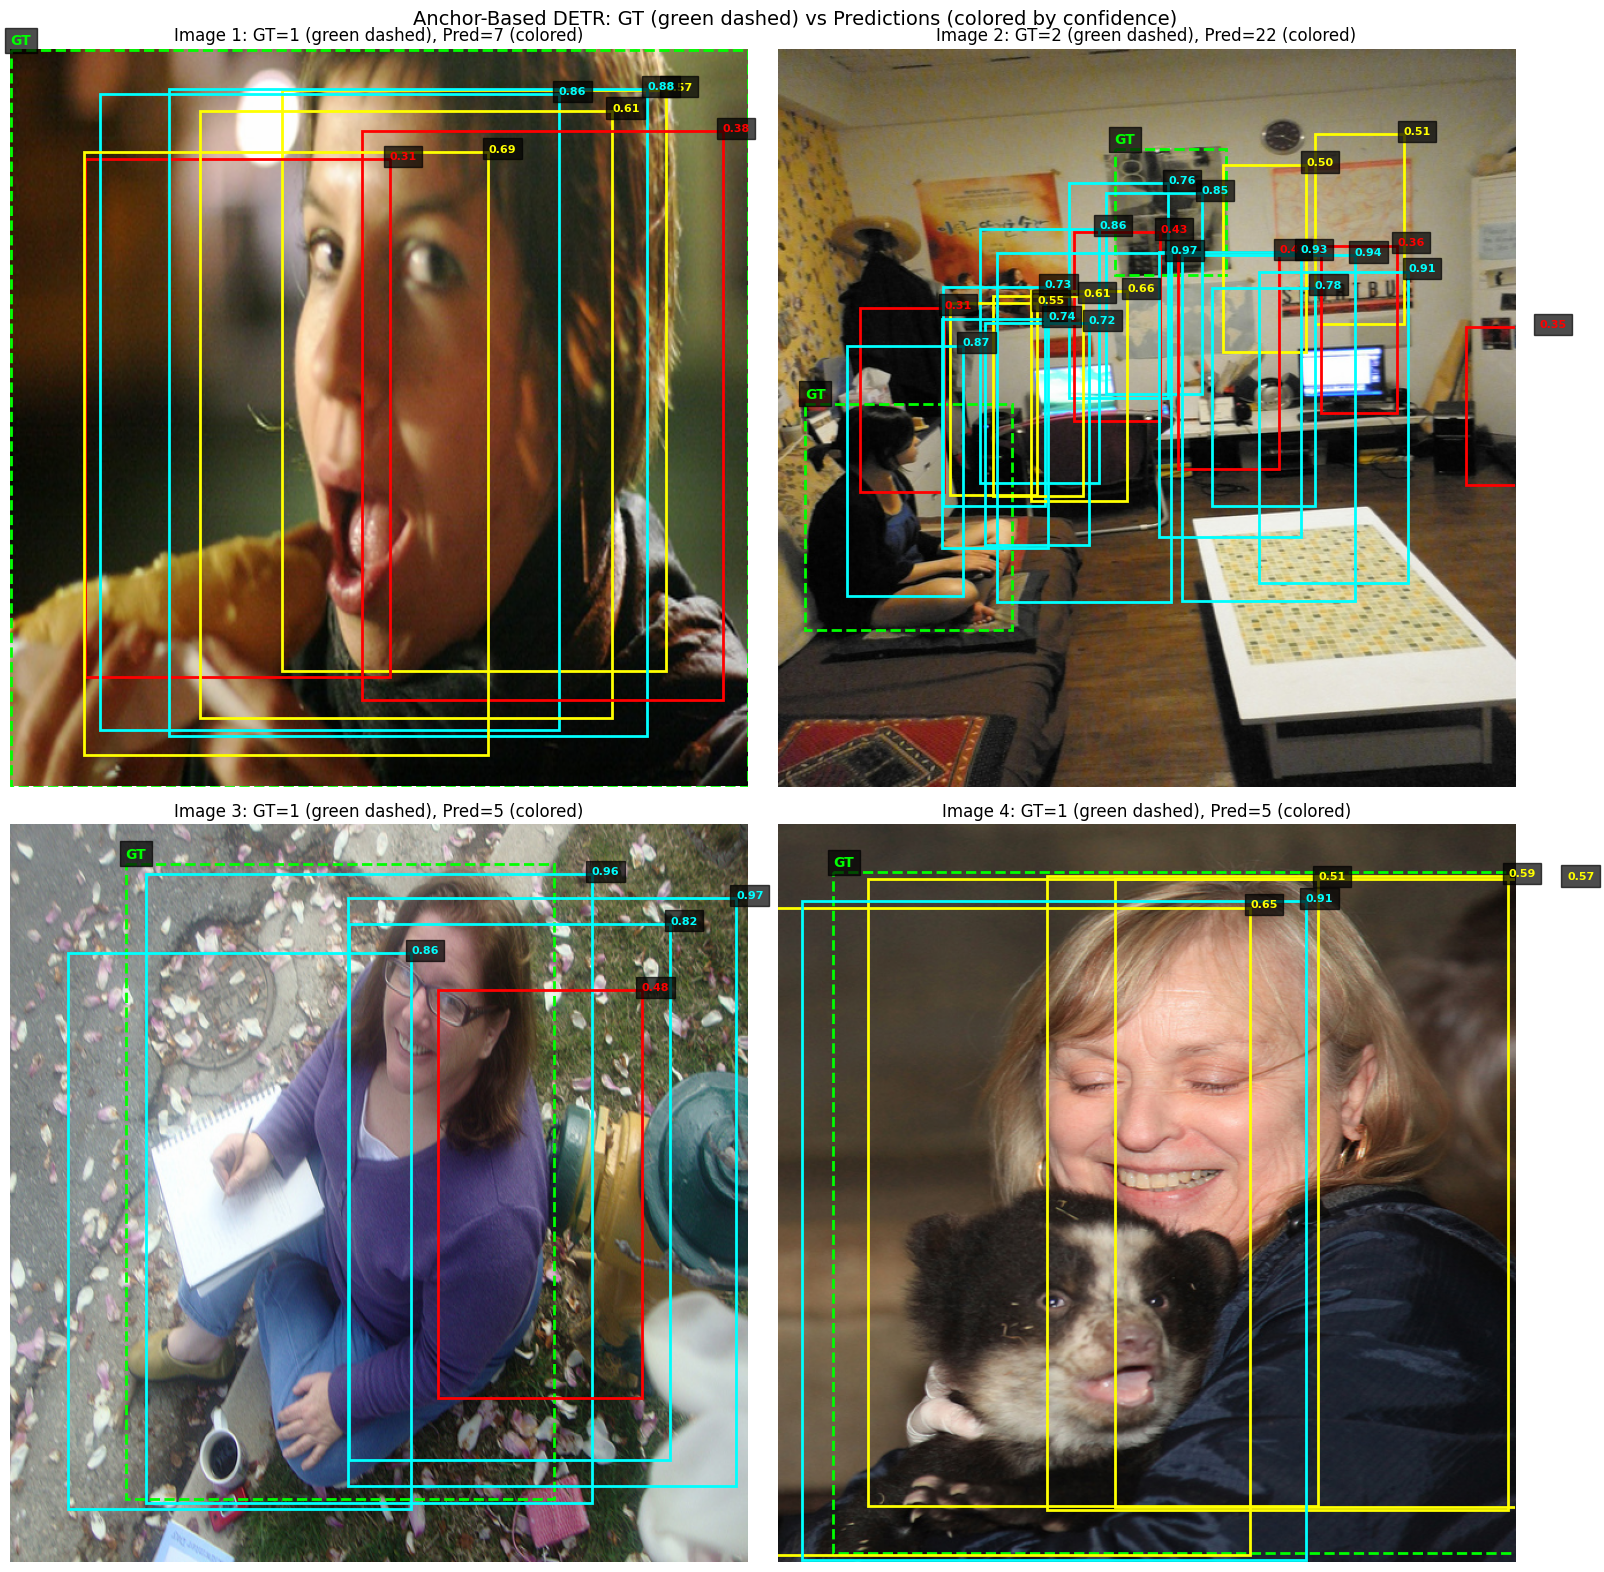


Detection summary:
Image 1: GT=1, Predictions=7
Image 2: GT=2, Predictions=22
Image 3: GT=1, Predictions=5
Image 4: GT=1, Predictions=5


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

images_vis, boxes_vis, labels_vis = next(iter(test_loader))
images_vis = images_vis[:4].to(lightning_module.device)

with torch.no_grad():
    outputs = lightning_module(images_vis)
    preds = lightning_module.model.postprocess(outputs, conf_threshold=0.3)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i in range(4):
    img = images_vis[i].cpu().numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    axes[i].imshow(img)
    
    for j in range(len(boxes_vis[i])):
        cx, cy, w, h = boxes_vis[i][j].numpy()
        x1 = (cx - w / 2) * TARGET_SIZE[1]
        y1 = (cy - h / 2) * TARGET_SIZE[0]
        w_px = w * TARGET_SIZE[1]
        h_px = h * TARGET_SIZE[0]
        
        rect = patches.Rectangle((x1, y1), w_px, h_px, linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        axes[i].add_patch(rect)
        axes[i].text(x1, y1-5, 'GT', color='lime', fontsize=10, weight='bold',
                     bbox=dict(facecolor='black', alpha=0.7))
    
    pred_boxes = preds[i]['boxes']
    pred_scores = preds[i]['scores']
    for j in range(len(pred_boxes)):
        cx, cy, w, h = pred_boxes[j].cpu().numpy()
        score = pred_scores[j].cpu().item()
        x1 = (cx - w / 2) * TARGET_SIZE[1]
        y1 = (cy - h / 2) * TARGET_SIZE[0]
        w_px = w * TARGET_SIZE[1]
        h_px = h * TARGET_SIZE[0]
        
        color = 'red' if score < 0.5 else 'yellow' if score < 0.7 else 'cyan'
        rect = patches.Rectangle((x1, y1), w_px, h_px, linewidth=2, edgecolor=color, facecolor='none')
        axes[i].add_patch(rect)
        axes[i].text(x1+w_px, y1, f'{score:.2f}', color=color, fontsize=8, weight='bold',
                     bbox=dict(facecolor='black', alpha=0.7))
    
    axes[i].set_title(f'Image {i+1}: GT={len(boxes_vis[i])} (green dashed), Pred={len(pred_boxes)} (colored)')
    axes[i].axis('off')

plt.suptitle('Anchor-Based DETR: GT (green dashed) vs Predictions (colored by confidence)', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nDetection summary:")
for i in range(4):
    print(f"Image {i+1}: GT={len(boxes_vis[i])}, Predictions={len(preds[i]['boxes'])}")


## Internal Components


### 1. Anchor Points Grid


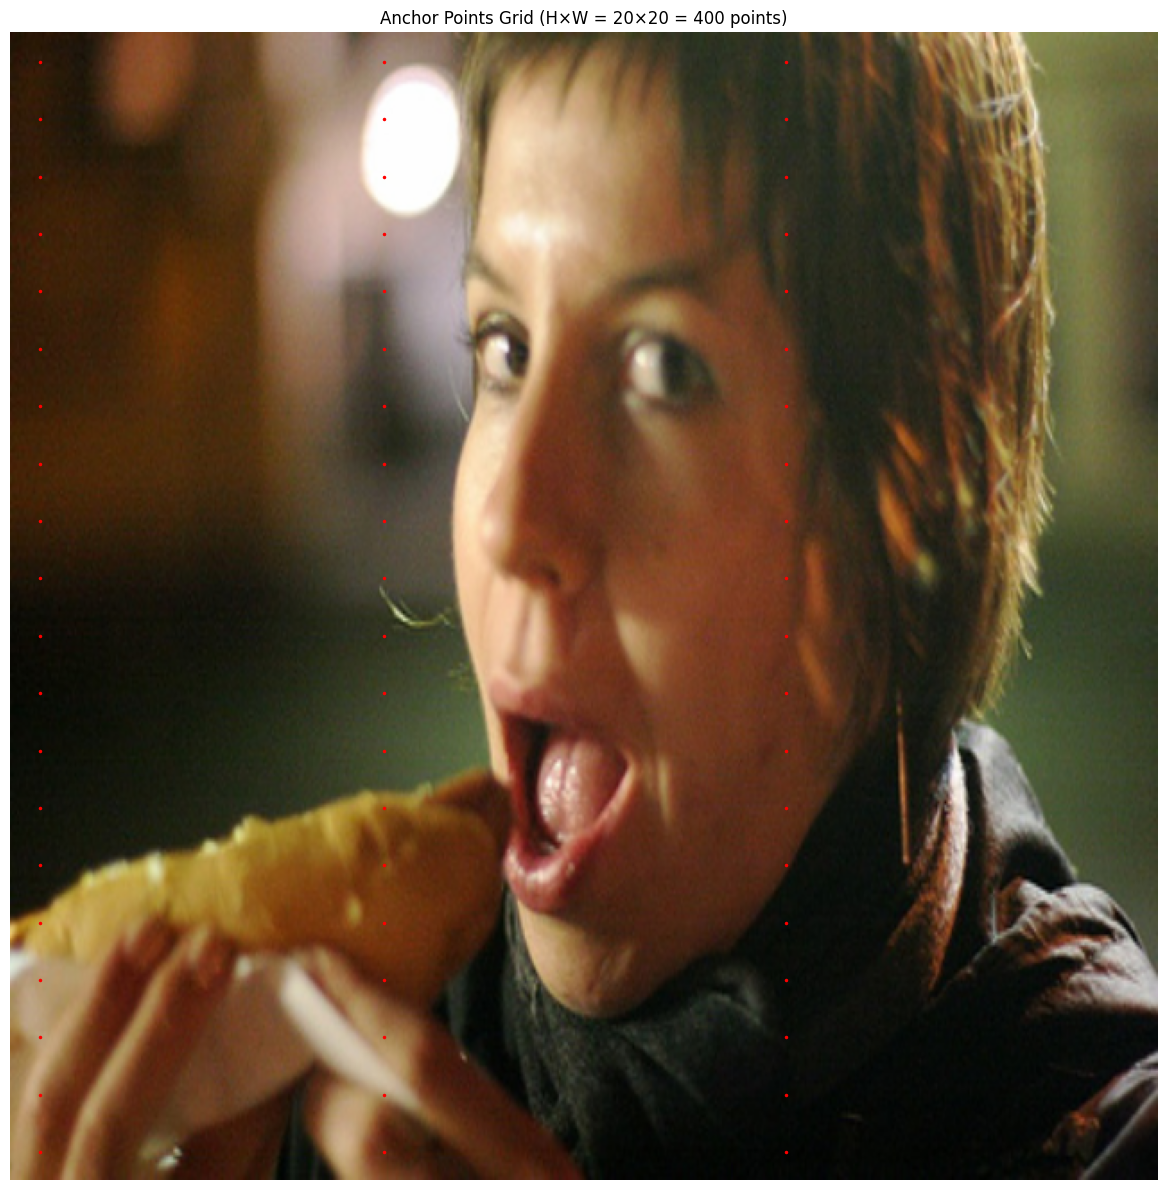

Feature map size: 20×20
Number of anchor points (queries): 1200
First 5 anchor points (normalized): [[0.02500000037252903, 0.02500000037252903], [0.02500000037252903, 0.02500000037252903], [0.02500000037252903, 0.02500000037252903], [0.07500000298023224, 0.02500000037252903], [0.07500000298023224, 0.02500000037252903]]


In [10]:
import torch.nn.functional as F

images_int, _, _ = next(iter(test_loader))
images_int = images_int[:1].to(lightning_module.device)

with torch.no_grad():
    features = lightning_module.model.backbone(images_int)
    outputs = lightning_module(images_int)
    anchor_points = outputs['anchor_points'][0]

H, W = features.shape[2:]

img = images_int[0].cpu().numpy().transpose(1, 2, 0)
img = img * std + mean
img = np.clip(img, 0, 1)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(img)

for i in range(0, len(anchor_points), 20):
    cx, cy = anchor_points[i].cpu().numpy()
    x = cx * TARGET_SIZE[1]
    y = cy * TARGET_SIZE[0]
    ax.plot(x, y, 'r.', markersize=3)

ax.set_title(f'Anchor Points Grid (H×W = {H}×{W} = {H*W} points)')
ax.axis('off')
plt.tight_layout()
plt.show()

print(f'Feature map size: {H}×{W}')
print(f'Number of anchor points (queries): {len(anchor_points)}')
print(f'First 5 anchor points (normalized): {anchor_points[:5].tolist()}')


### 2. Position Embedding Patterns


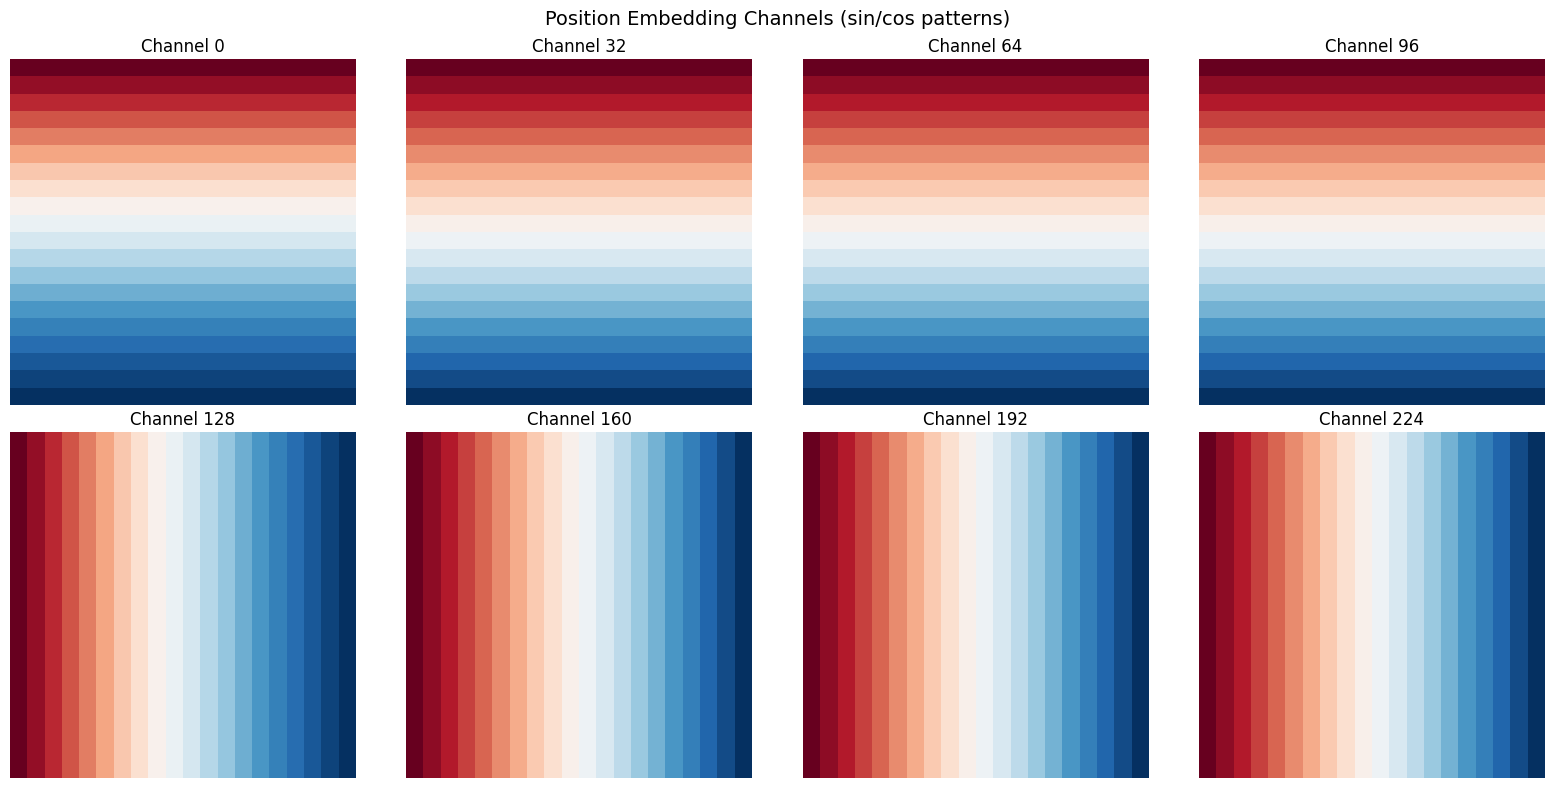

Position embedding shape: torch.Size([1, 256, 20, 20])


In [11]:
with torch.no_grad():
    pos_embed = lightning_module.model.pos_emb(features)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(8):
    ax = axes[i // 4, i % 4]
    ax.imshow(pos_embed[0, i * 32].cpu(), cmap='RdBu')
    ax.set_title(f'Channel {i*32}')
    ax.axis('off')
plt.suptitle('Position Embedding Channels (sin/cos patterns)', fontsize=14)
plt.tight_layout()
plt.show()
print(f'Position embedding shape: {pos_embed.shape}')


### 3. Top Confident Predictions


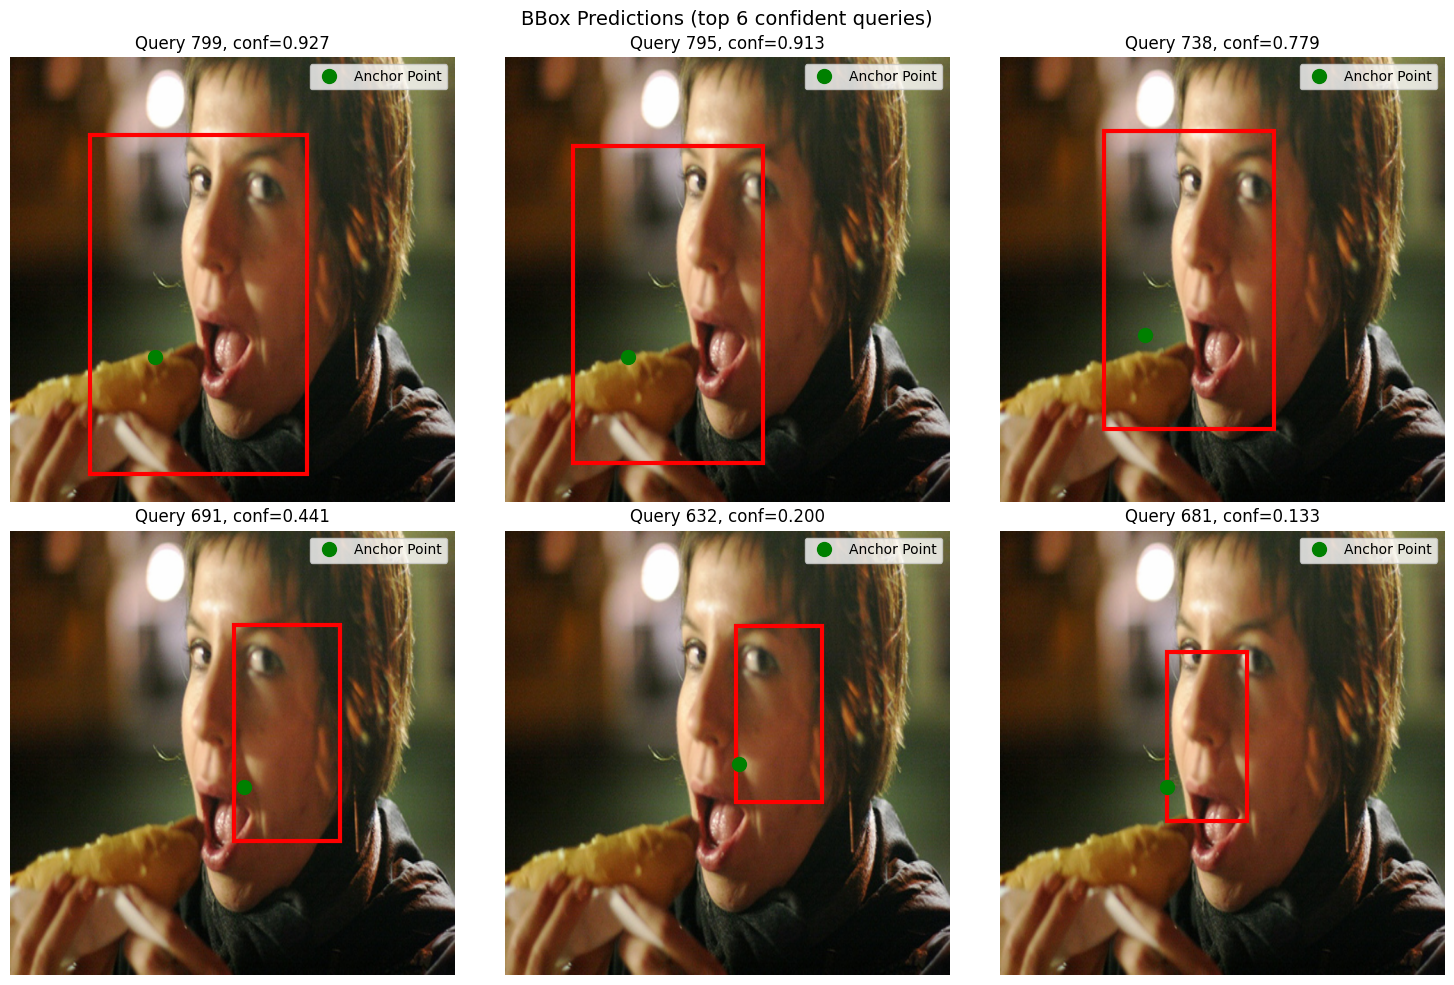

BBox predictions shape: torch.Size([1200, 4])
BBox coords range: [0.019, 0.982]


In [12]:
bbox_preds = outputs['bbox_pred'][0]
class_probs = torch.softmax(outputs['class_logits'][0], dim=-1)
person_probs = class_probs[:, 0]
top_queries = torch.argsort(person_probs, descending=True)[:6]

img = images_int[0].cpu().numpy().transpose(1, 2, 0)
img = img * std + mean
img = np.clip(img, 0, 1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for idx, q in enumerate(top_queries):
    ax = axes[idx // 3, idx % 3]
    ax.imshow(img)
    
    anchor_cx, anchor_cy = anchor_points[q].cpu().numpy()
    ax.plot(anchor_cx * TARGET_SIZE[1], anchor_cy * TARGET_SIZE[0], 'go', markersize=10, label='Anchor Point')
    
    cx, cy, w, h = bbox_preds[q].cpu().numpy()
    x1 = (cx - w / 2) * TARGET_SIZE[1]
    y1 = (cy - h / 2) * TARGET_SIZE[0]
    w_px = w * TARGET_SIZE[1]
    h_px = h * TARGET_SIZE[0]
    
    rect = patches.Rectangle((x1, y1), w_px, h_px, linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(f'Query {q.item()}, conf={person_probs[q]:.3f}')
    ax.axis('off')
    ax.legend(loc='upper right')
    
plt.suptitle('BBox Predictions (top 6 confident queries)', fontsize=14)
plt.tight_layout()
plt.show()
print(f'BBox predictions shape: {bbox_preds.shape}')
print(f'BBox coords range: [{bbox_preds.min():.3f}, {bbox_preds.max():.3f}]')
